In [ ]:
pip install imbalanced-learn

In [ ]:
pip install tensorflow-addons
pip install keras


In [1]:
import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
import tensorflow as tf




In [3]:
from tensorflow.keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose,InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
folder = 'C:/Users/is-os/Desktop/PythonProjects/alzheimer/Dataset'
folder_path = pathlib.Path(folder)

In [5]:
for file in listdir(folder):
    print(file)

Mild_Demented
Moderate_Demented
Non_Demented
Very_Mild_Demented


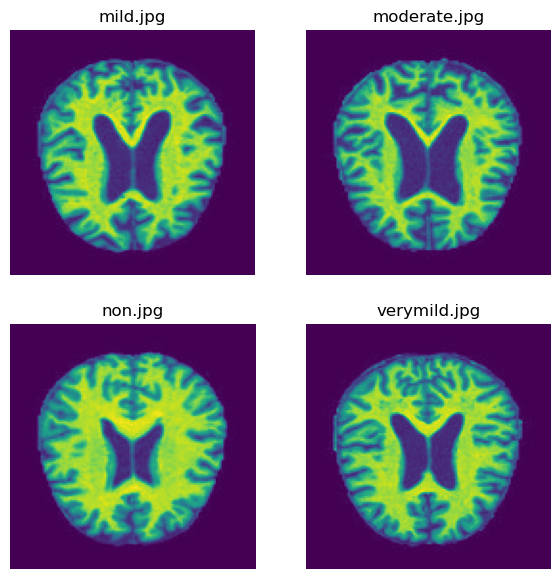

In [6]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [7]:
file_names = []
for file in listdir(folder):
    i = 0
    for image in listdir(folder + '/' + file):
        i += 1
    file_names.append(file)
    print(file, i)

print(file_names)


Mild_Demented 896
Moderate_Demented 64
Non_Demented 3200
Very_Mild_Demented 2240
['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<function matplotlib.pyplot.show(close=None, block=None)>

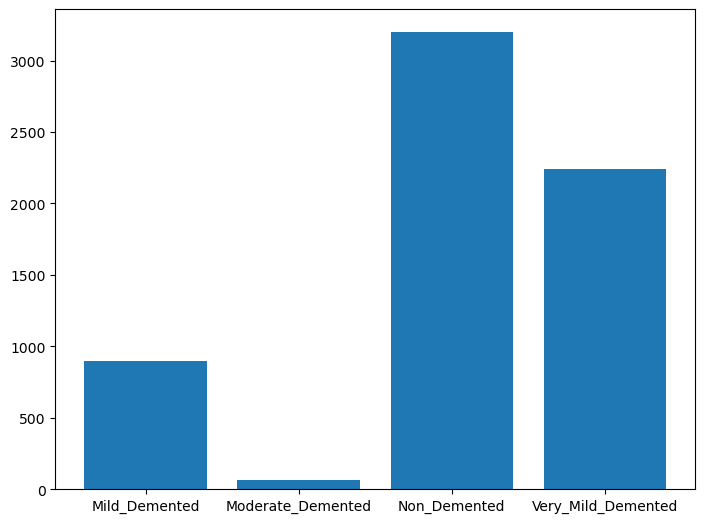

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(file_names,size)
plt.show

In [9]:
# Creating the image datagenerator to have more samples
IMG_S = 128
DIM = (IMG_S, IMG_S)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"


In [10]:
train_generator = ImageDataGenerator(rescale = 1./255)
                                     
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


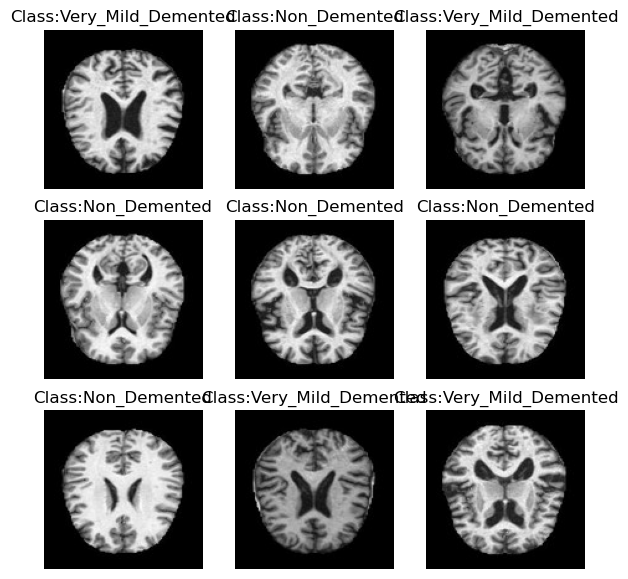

In [11]:
CLASSES = list(train_data_gen.class_indices.keys())

def show_images(generator,y_pred=None):
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(7, 7))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))                                                    
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [12]:
train_data, train_labels = train_data_gen.next()


In [13]:
train_data.shape, train_labels.shape


((6400, 128, 128, 3), (6400, 4))

In [14]:
#Since the data in each class is imbalanced we need to oversample the data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_S * IMG_S * 3), train_labels)

print(train_data.shape, train_labels.shape)

(12800, 49152) (12800, 4)


In [15]:
train_data = train_data.reshape(-1, IMG_S, IMG_S, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


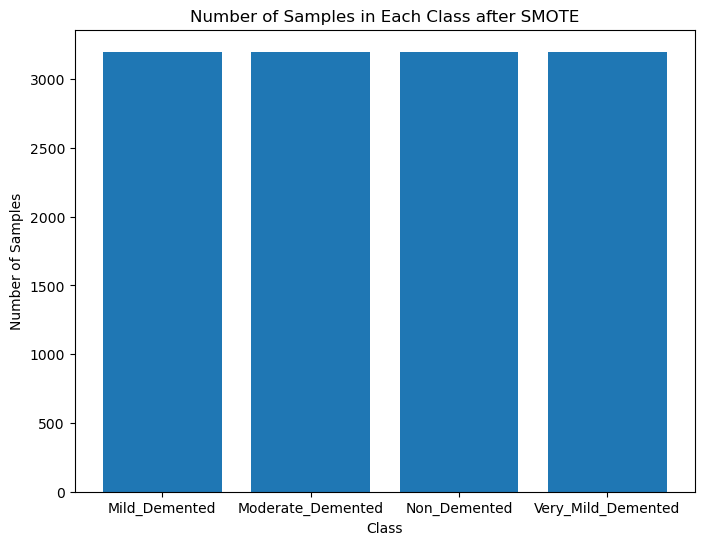

In [21]:
# Convert train_labels to class indices
train_labels_indices = np.argmax(train_labels, axis=1)

# Count the number of samples in each class
class_counts = np.bincount(train_labels_indices)

# Plot the count of samples in each class
plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(CLASSES)), [labels[i] for i in range(len(CLASSES))])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class after SMOTE')
plt.show()


In [22]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [23]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [24]:
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [25]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [28]:
from tensorflow.keras.layers import InputLayer

In [30]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model1")

In [32]:
print(tf.__version__)

2.6.0


In [33]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.Recall(name='RECALL'),
           tf.keras.metrics.Precision(name='PRECISION')]

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 32, 32, 32)        14016     
_________________________________________________________________
sequential_8 (Sequential)    (None, 16, 16, 64)        55680     
_________________________________________________________________
sequential_9 (Sequential)    (None, 8, 8, 128)         221952    
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [36]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/50
256/256 [==============================] - 95s 302ms/step - loss: 1.6384 - acc: 0.3271 - auc: 0.5893 - RECALL: 0.2067 - PRECISION: 0.3599 - val_loss: 2.5139 - val_acc: 0.2437 - val_auc: 0.4757 - val_RECALL: 0.0024 - val_PRECISION: 0.0794
Epoch 2/50
256/256 [==============================] - 56s 221ms/step - loss: 1.0015 - acc: 0.5543 - auc: 0.8205 - RECALL: 0.4148 - PRECISION: 0.6350 - val_loss: 1.6579 - val_acc: 0.2422 - val_auc: 0.5907 - val_RECALL: 0.2412 - val_PRECISION: 0.2544
Epoch 3/50
256/256 [==============================] - 56s 219ms/step - loss: 0.7674 - acc: 0.6389 - auc: 0.8899 - RECALL: 0.5167 - PRECISION: 0.7166 - val_loss: 1.6776 - val_acc: 0.4268 - val_auc: 0.7206 - val_RECALL: 0.4185 - val_PRECISION: 0.4364
Epoch 4/50
256/256 [==============================] - 56s 218ms/step - loss: 0.6783 - acc: 0.6910 - auc: 0.9142 - RECALL: 0.5886 - PRECISION: 0.7523 - val_loss: 0.6686 - val_acc: 0.6978 - val_auc: 0.9160 - val_RECALL: 0.5859 - val_PRECISION: 0.7673
Epoc

In [37]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 5s 62ms/step - loss: 0.0773 - acc: 0.9738 - auc: 0.9978 - RECALL: 0.9738 - PRECISION: 0.9742
Testing Accuracy: 97.38%


In [38]:
from tensorflow.keras.models import load_model
model.save('AD_CNN_NEW.h5')

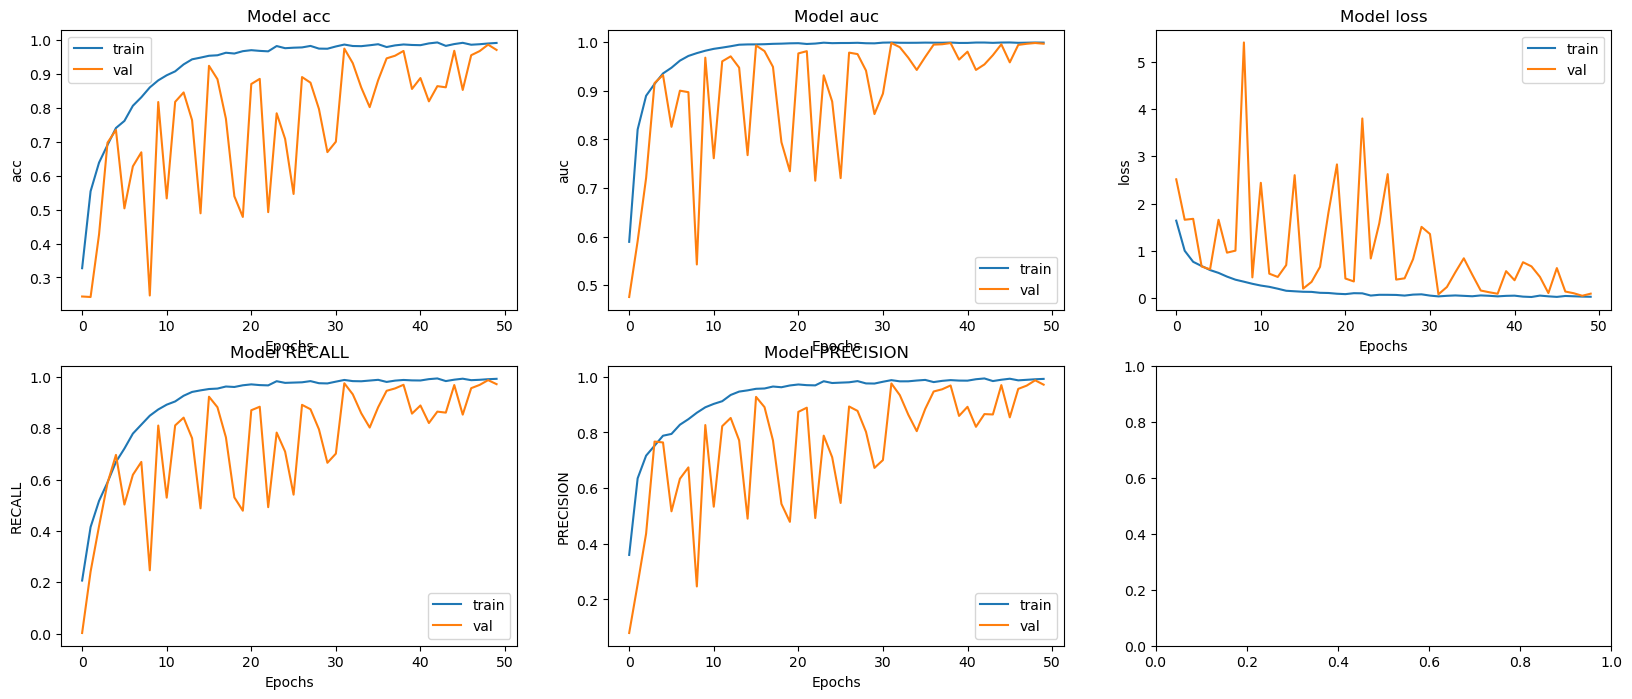

In [46]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss","RECALL","PRECISION"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [47]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')


In [71]:
 for layer in inception.layers:
    layer.trainable = False

In [49]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [50]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.keras.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 2, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_109 (Bat (None, 512)       

In [51]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incept_model_checkpoint_new.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [52]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50
256/256 [==============================] - 82s 255ms/step - loss: 1.3920 - acc: 0.5538 - auc: 0.8144 - RECALL: 0.4580 - PRECISION: 0.6450 - val_loss: 0.8011 - val_acc: 0.6230 - val_auc: 0.8819 - val_RECALL: 0.4941 - val_PRECISION: 0.7254
Epoch 2/50
256/256 [==============================] - 57s 223ms/step - loss: 0.8879 - acc: 0.5936 - auc: 0.8556 - RECALL: 0.4406 - PRECISION: 0.7079 - val_loss: 0.7029 - val_acc: 0.6543 - val_auc: 0.9027 - val_RECALL: 0.5527 - val_PRECISION: 0.7447
Epoch 3/50
256/256 [==============================] - 57s 224ms/step - loss: 0.7826 - acc: 0.6400 - auc: 0.8861 - RECALL: 0.4862 - PRECISION: 0.7487 - val_loss: 0.6342 - val_acc: 0.6982 - val_auc: 0.9219 - val_RECALL: 0.5811 - val_PRECISION: 0.7783
Epoch 4/50
256/256 [==============================] - 57s 223ms/step - loss: 0.7122 - acc: 0.6737 - auc: 0.9060 - RECALL: 0.5338 - PRECISION: 0.7758 - val_loss: 0.5918 - val_acc: 0.7227 - val_auc: 0.9330 - val_RECALL: 0.6079 - val_PRECISION: 0.7925
Epoc

In [53]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

80/80 [==============================] - 14s 173ms/step - loss: 0.1902 - acc: 0.9266 - auc: 0.9926 - RECALL: 0.9219 - PRECISION: 0.9317
Testing Accuracy: 92.66%


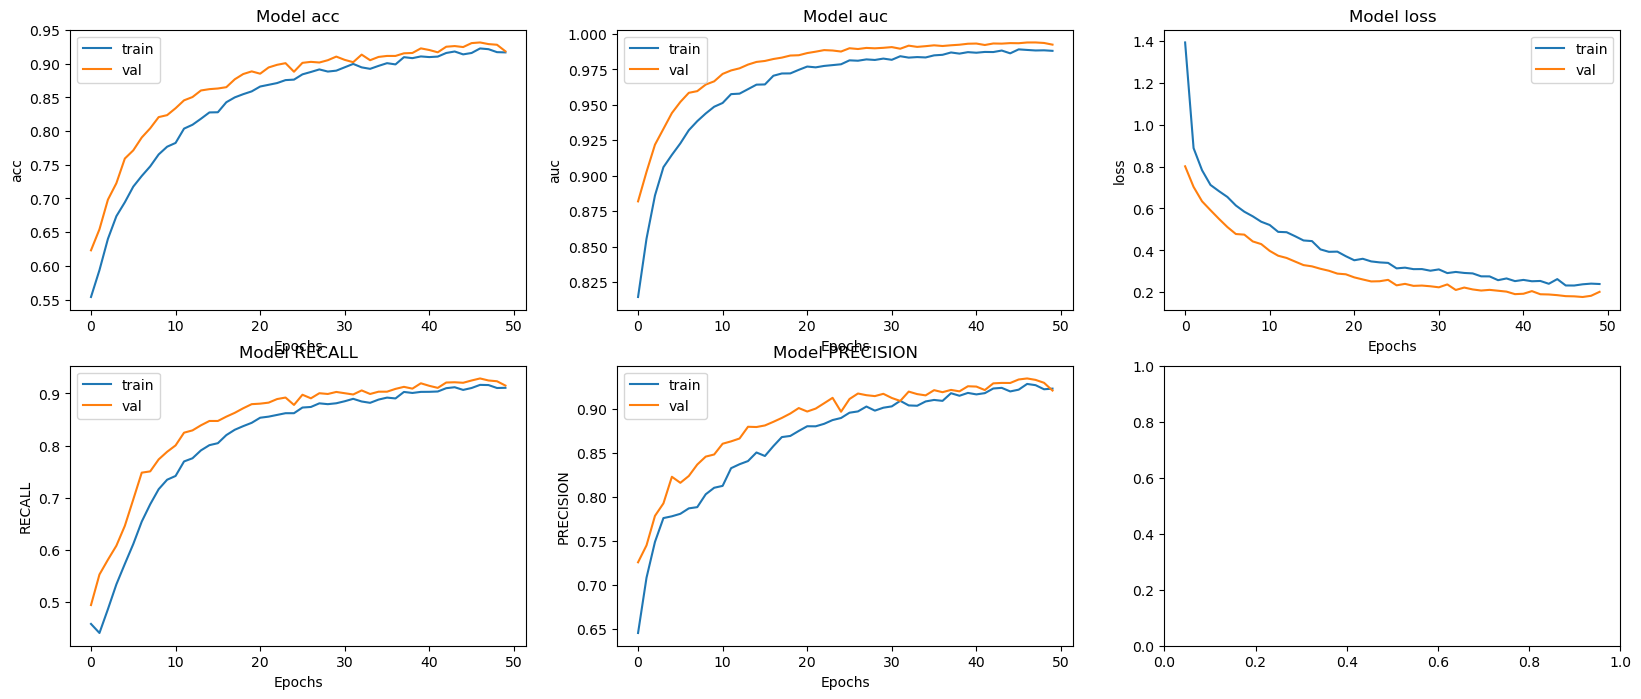

In [54]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(2, 3, figsize = (20, 8))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss","RECALL","PRECISION"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [55]:
inception_model.save('AD_CNN_incept_new.h5')

In [56]:
from tensorflow.keras.models import load_model

In [59]:
modelCNN = load_model('AD_CNN_new.h5')

In [60]:
test_scoresCNN = modelCNN.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scoresCNN[1] * 100))

80/80 [==============================] - 6s 59ms/step - loss: 0.0773 - acc: 0.9738 - auc: 0.9978 - RECALL: 0.9738 - PRECISION: 0.9742
Testing Accuracy: 97.38%


In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
predicted_labels = modelCNN.predict_classes(test_data)
true_labels = np.argmax(test_labels, axis=1)

In [64]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)


In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
predicted_labels = modelCNN.predict_classes(test_data)
true_labels = np.argmax(test_labels, axis=1)

In [42]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)


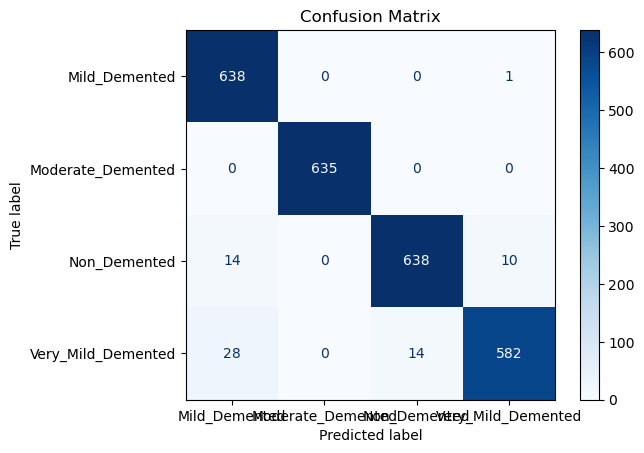

In [65]:
labels = file_names
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [66]:
modelINC = load_model('AD_CNN_incept_new.h5')


In [67]:
test_scoresINC = modelINC.evaluate(test_data, test_labels)
print("Testing Accuracy for INC: %.2f%%"%(test_scoresINC[1] * 100))

80/80 [==============================] - 16s 171ms/step - loss: 0.1902 - acc: 0.9266 - auc: 0.9926 - RECALL: 0.9219 - PRECISION: 0.9317
Testing Accuracy for INC: 92.66%


In [68]:
predicted_labelsINC = modelINC.predict_classes(test_data)
true_labelsINC = np.argmax(test_labels, axis=1)

In [69]:
confusion_matINC = confusion_matrix(true_labelsINC, predicted_labelsINC)


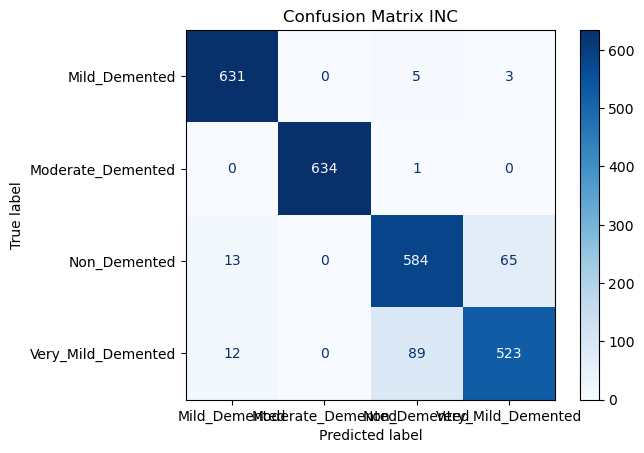

In [70]:
labels = file_names
cm_displayINC = ConfusionMatrixDisplay(confusion_matrix=confusion_matINC, display_labels=labels)
cm_displayINC.plot(cmap='Blues')
plt.title('Confusion Matrix INC')
plt.show()

In [72]:
from sklearn.metrics import classification_report

report = classification_report(true_labelsINC, predicted_labelsINC, target_names=file_names)

print(report)


                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.99      0.97       639
 Moderate_Demented       1.00      1.00      1.00       635
      Non_Demented       0.86      0.88      0.87       662
Very_Mild_Demented       0.88      0.84      0.86       624

          accuracy                           0.93      2560
         macro avg       0.93      0.93      0.93      2560
      weighted avg       0.93      0.93      0.93      2560



In [73]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=file_names)

print(report)

                    precision    recall  f1-score   support

     Mild_Demented       0.94      1.00      0.97       639
 Moderate_Demented       1.00      1.00      1.00       635
      Non_Demented       0.98      0.96      0.97       662
Very_Mild_Demented       0.98      0.93      0.96       624

          accuracy                           0.97      2560
         macro avg       0.97      0.97      0.97      2560
      weighted avg       0.97      0.97      0.97      2560

